In [12]:
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random

DATA_RAW_FOLDER = "data"
DATA_TRAIN_FOLDER = "data/train"
DATA_TEST_FOLDER = "data/test"

In [13]:
data = pathlib.Path(DATA_RAW_FOLDER)
images = []

In [14]:
for item in data.glob('*'):
  if item.name.endswith('png') or item.name.endswith('jpg') or item.name.endswith('jpeg') or item.name.endswith('JPG'):
      images.append(str(item))
#       shutil.copy(item, DATA_TRAIN_FOLDER)

len(images)

1838

In [15]:
!ls data/train/* | wc -l

1838


In [16]:
DATA_PRIVATE_TEST = "1015_Private Test"
test_data = pathlib.Path(DATA_PRIVATE_TEST)
test_images = []
for item in test_data.glob('*'):
  if item.name.endswith('png') or item.name.endswith('jpg') or item.name.endswith('jpeg') or item.name.endswith('JPG'):
      test_images.append(str(item))
#       shutil.copy(item, DATA_TEST_FOLDER)

len(test_images)

549

In [17]:
!ls data/test/* | wc -l

549


# Import library

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
%matplotlib inline
import mahotas 
import imutils

from collections import Counter
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json
import pandas as pd
# from google.colab.patches import cv2_imshow

# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.1.0


In [18]:
# finding where we are so we dont need to type absolute path everytime
current_directory_path = pathlib.Path(".").absolute()
current_directory_path

PosixPath('/home/jupyter/住所の認定')

In [19]:
# path to our directory images

# our train and test folder (not used for now but used later when we want to save images after processing)
DATA_PATH = os.path.join(str(current_directory_path), "data") #'/content/data'
TEST_FOLDER = os.path.join(DATA_PATH, "test")
TRAIN_FOLDER = os.path.join(DATA_PATH, "train")

# our raw folders
# RAW_TEST_FOLDER = os.path.join(DATA_PATH, "raw")

print(DATA_PATH)
print(TEST_FOLDER)
print(TRAIN_FOLDER)

/home/jupyter/住所の認定/data
/home/jupyter/住所の認定/data/test
/home/jupyter/住所の認定/data/train


In [20]:
# checking if GPU is available 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # RIP Training time
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [21]:
with open(os.path.join('data/', 'labels.json')) as json_file:
  labels_jason = json.load(json_file)

labels_jason

{'1.jpg': 'Số 3 Nguyễn Ngọc Vũ, Hà Nội',
 '2.jpg': 'Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội',
 '3.jpg': '58 Thái Thịnh, Đống Đa, Hà Nội',
 '4.jpeg': 'Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai',
 '5.jpg': 'Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung',
 '6.jpg': 'Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội',
 '7.jpg': '40 Cát Linh, Đống Đa, Hà Nội',
 '8.jpg': 'phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm',
 '9.JPG': 'Nhà 87 ngõ 416 Đê La Thành',
 '10.JPG': 'Up coworking Space, 89 Láng Hạ, Hà Nội',
 '11.jpg': '192 Ngô Đức Kế, quận 1, Hồ Chí Minh',
 '12.jpg': 'số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1',
 '13.jpg': '90A đường Mai Xuân Thưởng, tỉnh Gia Lai',
 '14.jpg': '96/7/12B Phạm Văn Đồng, thành phố Pleiku',
 '15.jpg': '168 Ngô Gia Tự, thành phố Hà Tĩnh',
 '0000_samples.png': 'Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương',
 '0001_samples.png': 'Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạnh, TP Hồ Chí Minh',
 '

In [22]:
with open(os.path.join('1015_Private Test/', 'labels.json')) as json_file:
  test_labels_jason = json.load(json_file)

test_labels_jason

{'0000_tests.png': 'Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau',
 '0001_tests.png': '271 Huỳnh Ngọc Huệ, Phường Hoà Khê, Quận Thanh Khê, Đà Nẵng',
 '0002_tests.png': 'Số 35/70B, KP 9, Phường Hố Nai, Thành Phố Biên Hoà, Đồng Nai',
 '0003_tests.png': 'Số 187, tổ 8, ấp Tân Hòa, Xã Tân Tiến, Huyện Bù Đốp, Bình Phước',
 '0004_tests.png': 'Số 47, tổ 2D, khu 1, Phường Gia Cẩm, Thành phố Việt Trì, Phú Thọ',
 '0005_tests.png': 'Thôn Cầu Đen, Xã Thanh Xuân, Huyện Sóc Sơn, Hà Nội',
 '0006_tests.png': '35 Ni Sư Huỳnh Liên, Phường 10, Quận Tân Bình, TP Hồ Chí Minh',
 '0007_tests.png': 'Số 33 Trần Cao Vân, Phường Ngọc Trạo, Thành phố Thanh Hoá, Thanh Hoá',
 '0008_tests.png': 'Số 99 phố Yên Phúc, Phường Phúc La, Quận Hà Đông, Hà Nội',
 '0009_tests.png': 'Số 12, ngõ 11, phố Thái Hà, Phường Trung Liệt, Quận Đống đa, Hà Nội',
 '0010_tests.png': 'Số 9 lô 5/6A Bạch Đằng, Phường Hạ Lý, Quận Hồng Bàng, Hải Phòng',
 '0011_tests.png': '6/2 Lầu Tân Khai, Phường 4, Quận 11, TP Hồ Chí Minh',
 '0

# Reading images and organise folders

In [23]:
# checking the total alphabet characters of the whole dataset
char_list= set()
for item in labels_jason.values():
    char_list.update(set((item)))
char_list=sorted(char_list)

print("Total number of characters : {}".format(len(char_list)))

Total number of characters : 140


In [24]:
# checking the total alphabet characters of the whole dataset
test_char_list= set()
for item in test_labels_jason.values():
    test_char_list.update(set((item)))
test_char_list=sorted(test_char_list)

print("Total number of characters : {}".format(len(test_char_list)))

Total number of characters : 134


In [25]:
# show all possible labels characters
"".join(char_list)

" #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [26]:
# show all possible labels characters
"".join(test_char_list)

" #'(),-./0123456789ABCDEFGHIJKLMNOPQRSTUVXYabcdeghiklmnopqrstuvwxyÂÔàáâãèéêìíòóôõùúýăĐđĩũơưạảấầẩẫậắằẵặẹẻẽếềểễệỉịọỏốồổỗộớờởợụủứừửữựỳỵỷỹ"

In [27]:
# find the maximum label length
label_lens= []
for label in labels_jason.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)
max_label_len

69

In [28]:
# convert the words to array of indexs based on the char_list
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [29]:
encode_to_labels(" '123ABCDE") 

[0, 2, 11, 12, 13, 21, 22, 23, 24, 25]

In [30]:
# all possible image paths for training
all_image_paths = ['data/train/' + str(path) for path in labels_jason.keys()]
len(all_image_paths)

1838

In [31]:
test_image_paths = ['1015_Private Test/' + str(path) for path in test_labels_jason.keys()]
len(test_image_paths)

549

In [32]:
# find all widths and heights of images (this is useful if our dataset images got different sizes)
widths = []
heights = []
for image_path in all_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)
(min_height, max_height, min_width, max_width)

(94, 376, 955, 2694)

In [109]:
# # being a good Data Scientist, we need to have train set and test set
# from sklearn.model_selection import train_test_split

# test_size = 0.1
# train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

# Data Preprocessing

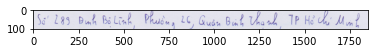

In [18]:
file_name = 'data/train/0001_samples.png'
image = cv2.imread(file_name)
plt.imshow(imutils.opencv2matplotlib(image))
plt.show()

In [33]:
# in this dataset, we need to do resizing all images to have the same height of min_height
# for width we apply padding horizontally following the new max width of resized images

# find all widths and heights of images (this is useful if our dataset images got different sizes)
new_widths = []
new_heights = []

max_height = 128

for image_path in all_image_paths:
    image = cv2.imread(image_path)
    (height, width, _) = image.shape
    image = imutils.resize(image, height=max_height)
    (new_height, new_width, _) = image.shape
    new_heights.append(new_height)
    new_widths.append(new_width)

new_min_height = min(new_heights)
new_max_height = max(new_heights)
new_min_width = min(new_widths)
new_max_width = max(new_widths)
(new_min_height, new_max_height, new_min_width, new_max_width)

(128, 128, 840, 2350)

In [34]:
max_height

128

In [35]:
TIME_STEPS = 293 #max_label_len

In [37]:
# BUILD THE PIPELINE FOR ALL IMAGES

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0

global_max_width = 2350
new_max_height = 128

for train_image_path in all_image_paths:
    img = cv2.cvtColor(cv2.imread(train_image_path), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img, (7,7),0)
    gau= cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 4)

    (height, width) = gau.shape
    img = imutils.resize(gau, height=max_height)
    new_height, new_width = img.shape[0], img.shape[1]
    diff_hori = new_max_width - new_width
    # pad_left = diff_hori//2
    # pad_right = diff_hori - pad_left
    constant= cv2.copyMakeBorder(img,0,0,0, diff_hori, cv2.BORDER_CONSTANT, value=0)

    # add channel dimension
    img = np.expand_dims(constant , axis = 2)

    # Normalize each image
    img = img/255.
    image_path_key = train_image_path[11:]
    label = labels_jason[image_path_key]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%100 == 0):
        print ("has processed trained {} files".format(i))


has processed trained 100 files
has processed trained 200 files
has processed trained 300 files
has processed trained 400 files
has processed trained 500 files
has processed trained 600 files
has processed trained 700 files
has processed trained 800 files
has processed trained 900 files
has processed trained 1000 files
has processed trained 1100 files
has processed trained 1200 files
has processed trained 1300 files
has processed trained 1400 files
has processed trained 1500 files
has processed trained 1600 files
has processed trained 1700 files
has processed trained 1800 files


In [31]:
train_input_length[:3]

[293, 293, 293]

In [38]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

global_max_width = 2350
new_max_height = 128

for test_img_path in test_image_paths:
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img, (7,7),0)
    gau= cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 4)

    (height, width) = gau.shape
    img = imutils.resize(gau, height=max_height)

    new_height, new_width = img.shape[0], img.shape[1]
    diff_hori = new_max_width - new_width
    # pad_left = diff_hori//2
    # pad_right = diff_hori - pad_left
    if diff_hori >= 0:
        constant= cv2.copyMakeBorder(img,0,0,0, diff_hori, cv2.BORDER_CONSTANT, value=0)
    else:
        img = imutils.resize(gau, width = global_max_width)
        new_height, new_width = img.shape[0], img.shape[1]
        diff_verti = new_max_height - new_height
        constant= cv2.copyMakeBorder(img,0,diff_verti,0,0, cv2.BORDER_CONSTANT, value=0)
        
    # add channel dimension
    img = np.expand_dims(constant , axis = 2)

    # Normalize each image
    img = img/255.

    image_path_key = test_img_path.split('/')[-1]
    label = test_labels_jason[image_path_key]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%100 == 0):
        print ("has processed test {} files".format(i))

No found in char_list : ẫ
No found in char_list : ẹ
has processed test 100 files
has processed test 200 files
has processed test 300 files
has processed test 400 files
has processed test 500 files


In [46]:
len(valid_img)

549

In [39]:
max_label_len = TIME_STEPS #69->270
max_label_len

293

In [40]:
# pad each output label to maximum text length, so that we keep training with rnn consistent
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)

In [41]:
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

# Model Building

In [121]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=128 and width=2350 
inputs = Input(shape=(new_min_height,new_max_width,1))
 
# convolution layer with kernel size (3,3)  #
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2 
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_1)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2 
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_3)

pool_4 = MaxPool2D(pool_size=(3, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# batch_norm_5 = BatchNormalization()(conv_5)

# poolig layer with kernel size (2,2) to make the height/2
pool_5 = MaxPool2D(pool_size=(3, 1))(conv_5)

# # to remove the first dimension of one
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_5)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.7))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.7))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

### ctc definition part 
"""
The reason why we use ctc_batch_cost instead of ctc_cost because
In batch cost, the program managed to mask out padded sequence using label_length, 
So the cost won't include the padding 0 section.
"""

"""
The way CTC is modelled currently in Keras is that you need to implement the loss function as a layer, you did that already (loss_out). 
Your problem is that the inputs you give that layer are not tensors from Theano/TensorFlow but numpy arrays.
To change that one option is to model these values as inputs to your model.
That is why we need to manually create Input for labels, input length and label_length.
"""

# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    """
    labels: tensor (number of samples, max_string_length) containing the truth labels.
    y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
    input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
    label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
    """
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)


In [122]:
# ready ctc loss function and optimizers
opt = opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = opt)

# our callbacks hell to optimize our learning
callbacks = [
    TensorBoard(
        log_dir='./logs_6',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='/home/jupyter/住所の認定/checkpoint_weights_6.hdf5',
        monitor='loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='loss',
        min_delta=1e-8,
        factor=0.2,
        patience=5,
        verbose=1)
]
callbacks_list = callbacks

# notice I convert everything to numpy array here since model can fit either tensors and numpy array
# the reason why i stick with numpy array because it is simple to code and also because it is baseline solution
# I want to use openCV (can't run with tensors because it is CPU operations)
# And if I want to use tensors then i will make sure my image preprocessing functions uses tensor compatible operations

# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
# valid_img = np.array(valid_img)
# valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
# valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 2350, 1 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 2350, 64 640         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 64, 1175, 64) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 1175, 64) 36928       max_pooling2d_11[0][0]           
____________________________________________________________________________________________

In [34]:
# choose batchsize and epochs
%time

tf.random.set_seed(42)

batch_size = 32
epochs = 100

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          verbose = 1, callbacks = callbacks_list)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.3 µs
Train on 1838 samples
Epoch 1/100
1824/1838 [============================>.] - ETA: 0s - loss: 247.1329
Epoch 00001: loss improved from inf to 246.80457, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 24s 13ms/sample - loss: 246.8046
Epoch 2/100
1824/1838 [============================>.] - ETA: 0s - loss: 199.4943
Epoch 00002: loss improved from 246.80457 to 199.37723, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 199.3772
Epoch 3/100
1824/1838 [============================>.] - ETA: 0s - loss: 194.0256
Epoch 00003: loss improved from 199.37723 to 193.88876, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 193.8888
Epoch 4/100
1824/1838 [============================>.] - ETA: 0s - loss: 189.9917
Epoc

In [35]:
model.save('./model.h5')

In [36]:
# choose batchsize and epochs
%time

tf.random.set_seed(42)

batch_size = 32
epochs = 10

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          verbose = 1, callbacks = callbacks_list)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
Train on 1838 samples
Epoch 1/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.5255
Epoch 00001: loss did not improve from 0.51241
1838/1838 [==============================] - 21s 11ms/sample - loss: 0.5254
Epoch 2/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.5055
Epoch 00002: loss improved from 0.51241 to 0.50586, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 0.5059
Epoch 3/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.4981
Epoch 00003: loss improved from 0.50586 to 0.49885, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 0.4989
Epoch 4/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.4917
Epoch 00004: loss improved from 0.49885 to 0.49035, saving model to /home/jupyter/住所の認定/checkpo

In [37]:
# choose batchsize and epochs
%time

tf.random.set_seed(42)

batch_size = 32
epochs = 10

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          verbose = 1, callbacks = callbacks_list)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Train on 1838 samples
Epoch 1/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.3301
Epoch 00001: loss improved from 0.45523 to 0.32962, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 21s 11ms/sample - loss: 0.3296
Epoch 2/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.3167
Epoch 00002: loss improved from 0.32962 to 0.31630, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 0.3163
Epoch 3/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.3019
Epoch 00003: loss improved from 0.31630 to 0.30080, saving model to /home/jupyter/住所の認定/checkpoint_weights_6.hdf5
1838/1838 [==============================] - 20s 11ms/sample - loss: 0.3008
Epoch 4/10
1824/1838 [============================>.] - ETA: 0s - loss: 0.2938
Epoch 00004: loss improved f

In [ ]:
model.save('./final_model.h5')

# Test on private test set

In [81]:
# load the saved best model weights
act_model.load_weights('./final_model.h5')

In [82]:
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [83]:
# predict outputs on validation images
NO_PREDICTS = 10
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
#prediction = act_model.predict(valid_img)

In [85]:
# NO_PREDICTS image results
# 270 timesteps
# 139 chars + 1 blank
prediction.shape

(10, 293, 141)

In [86]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

original_text  =  Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau
predicted text = Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau
original_text  =  271 Huỳnh Ngọc Huệ, Phường Hoà Khê, Quận Thanh Khê, Đà Nẵng
predicted text = 271 Huỳnh Ngọc Huệ, Phường Hoà Khê, Quận Thanh Khê, Đà Nẵng
original_text  =  Số 35/70B, KP 9, Phường Hố Nai, Thành Phố Biên Hoà, Đồng Nai
predicted text = Số 35/30B, KP 9, Phờng Hố Nai, Thành Phố Bên Hoà, Đồng Nai
original_text  =  Số 187, tổ 8, ấp Tân Hòa, Xã Tân Tiến, Huyện Bù Đốp, Bình Phước
predicted text = Số 18D, # 6, ãp Tân Hoà, Xã Tân Trún, Huyện Bù Đốn, Bình Phuận
original_text  =  Số 47, tổ 2D, khu 1, Phường Gia Cẩm, Thành phố Việt Trì, Phú Thọ
predicted text = Số 47, tổ 2B, khu 1, Phường Gia Cấn, Thành phố Vườt Trà, Phú Th ịn
original_text  =  Thôn Cầu Đen, Xã Thanh Xuân, Huyện Sóc Sơn, Hà Nội
predicted text = Tân Cầu Đu, Xã Trạnh Xuân, Huyện Sóc Sơn, Hà Nội
original_text  =  35 Ni Sư Huỳnh Liên, Phường 10, Quận Tân Bình, TP Hồ 

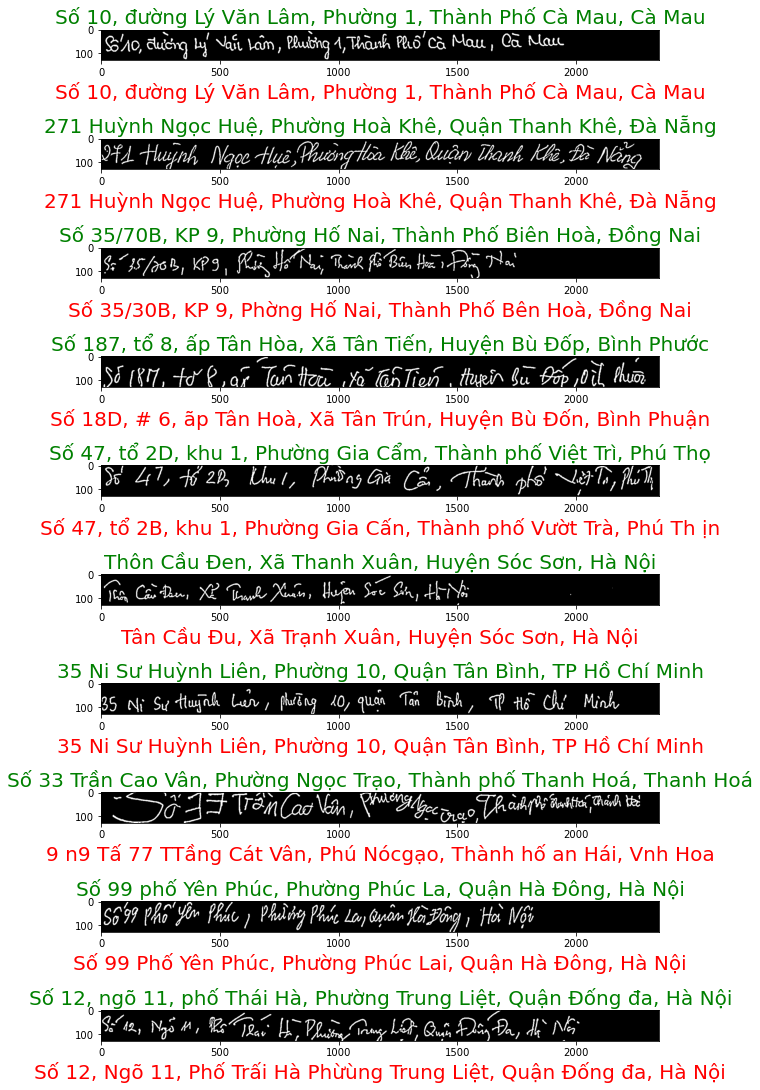

In [87]:
#YOUR PART: WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize=(10,20))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.title(valid_orig_txt[n+OFFSET], fontsize=20, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel(all_predictions[n+OFFSET], fontsize=20, color="red")


### Evaluation using CER, WER and SER


In [78]:
# ! pip install editdistance

In [88]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [89]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

print(e_corpus)

Metrics:
Character Error Rate: 0.10754718033277248
Word Error Rate:      0.2622086247086247
Sequence Error Rate:  0.7
